In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import geopandas
import scipy
import geopy.distance as gd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from collections import Counter
from shapely.geometry import Point, Polygon

### 1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
TARGET = 'price'

print(data.shape)

(48895, 16)


In [3]:
data.head(8)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220


### 2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

In [4]:
#Посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
#Проверим пустые значения
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
#Дубликаты
sum(data['id'].duplicated())

0

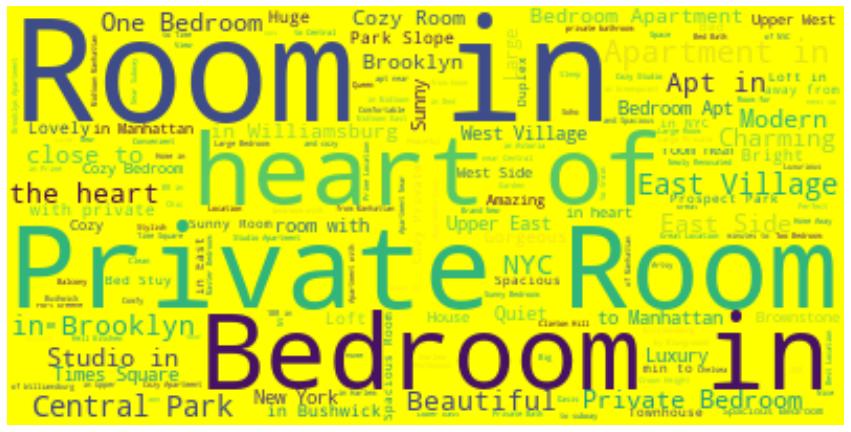

In [7]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in data.name)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200, background_color="yellow").generate(text)
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
#Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.
data.drop(["id", "host_name", "name", "host_id", "last_review"], axis="columns", inplace=True)

In [9]:
data.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

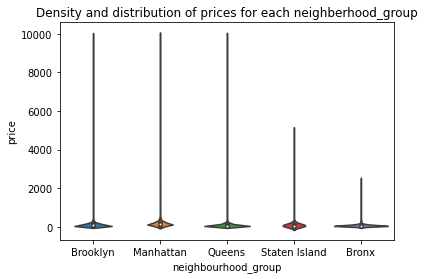

In [10]:
viz_2=sns.violinplot(data=data, x='neighbourhood_group', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

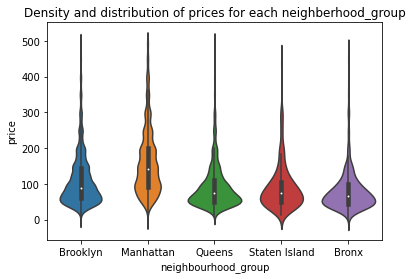

In [11]:
#Сделать переменную дорогое и дешевое жилье
sub_data=data[data.price < 500]
viz_2=sns.violinplot(data=sub_data, x='neighbourhood_group', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

In [12]:
data.neighbourhood.value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Fort Wadsworth           1
Rossville                1
Richmondtown             1
New Dorp                 1
Woodrow                  1
Name: neighbourhood, Length: 221, dtype: int64

<BarContainer object of 30 artists>

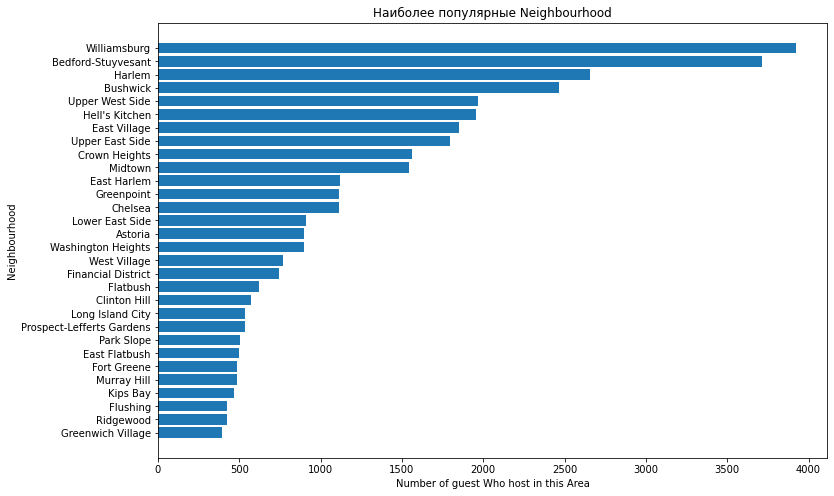

In [13]:
# что с ней сделать? расбить на популяные и нет , убрать 1 , или ее совсем убрать
df = data.neighbourhood.value_counts()[:30]
plt.figure(figsize=(12, 8))
x = list(df.index)
y = list(df.values)
x.reverse()
y.reverse()

plt.title("Наиболее популярные Neighbourhood")
plt.ylabel("Neighbourhood")
plt.xlabel("Number of guest Who host in this Area")

plt.barh(x, y)


In [14]:
#latitude','longitude'
data['latitude'].describe()

count    48895.000000
mean        40.728949
std          0.054530
min         40.499790
25%         40.690100
50%         40.723070
75%         40.763115
max         40.913060
Name: latitude, dtype: float64

In [15]:
data['longitude'].describe()

count    48895.000000
mean       -73.952170
std          0.046157
min        -74.244420
25%        -73.983070
50%        -73.955680
75%        -73.936275
max        -73.712990
Name: longitude, dtype: float64

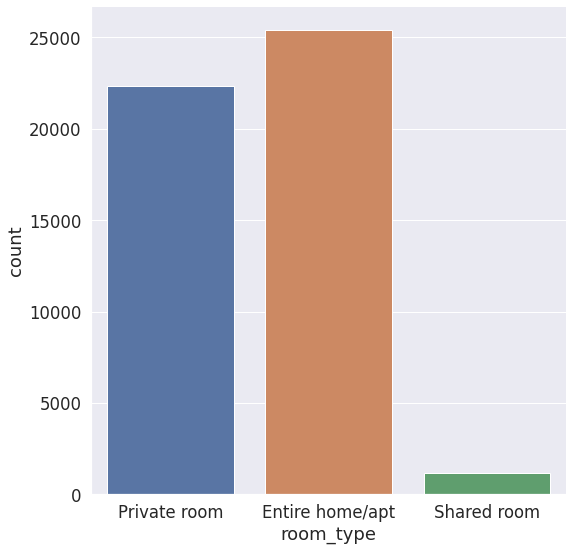

In [16]:
sns.set(font_scale=1.5)
sns.catplot("room_type", data=data, kind="count", height=8)

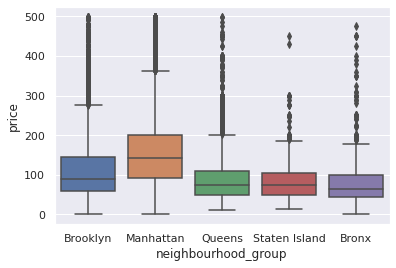

In [17]:
sns.set(font_scale=1);
sns.boxplot(x='neighbourhood_group', y='price', data=data[data.price < 500]);
#Манхетен Бруклин и все остальные? 
# Цена 300 выше выбросы

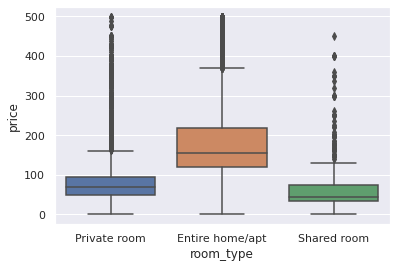

In [18]:
sns.set(font_scale=1);
sns.boxplot(x='room_type', y='price', data=data[data.price < 500]);
#Объединить private и shared в одну ?

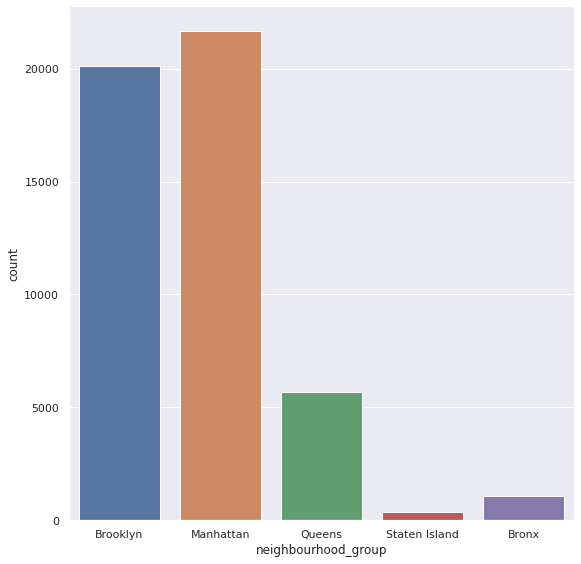

In [19]:
sns.catplot("neighbourhood_group", data=data, kind="count", height=8)

In [20]:
print(data['price'].describe());
#цена 0? убрать?

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


(array([3.1783e+04, 5.4950e+03, 2.7250e+03, 1.9330e+03, 1.3620e+03,
        1.1200e+03, 8.5200e+02, 6.3000e+02, 5.3200e+02, 4.3700e+02,
        3.9500e+02, 2.8600e+02, 2.3900e+02, 1.9100e+02, 1.5500e+02,
        1.3400e+02, 1.3300e+02, 9.5000e+01, 8.5000e+01, 5.2000e+01,
        4.4000e+01, 3.8000e+01, 2.7000e+01, 2.0000e+01, 1.4000e+01,
        2.6000e+01, 1.3000e+01, 1.0000e+01, 1.1000e+01, 7.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 4.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  0.  ,  12.58,  25.16,  37.74,  50.32,  62.9 ,  75.48,  88.06,
        100.64, 113.22, 125.8 , 138.38, 150.96, 163.54, 176.12, 188.7 ,
        201.28, 213.86, 226.44, 239.02, 251.6 , 264.18, 276.76, 289.34,
        301.92, 314.5 , 327.08, 339.66, 352.24, 364.82, 377.4 , 389.98,
        402.56, 415.14, 427.72

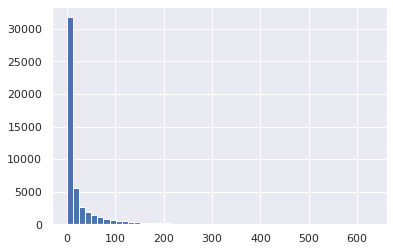

In [21]:
plt.hist(data['number_of_reviews'], bins=50)
#? 

In [22]:
rev_group = pd.DataFrame(data.groupby('number_of_reviews').sum()['price'])
most_reviewed = (rev_group.sort_values('number_of_reviews',ascending=False)).head(3)
most_reviewed.columns = ['Price']
most_reviewed['Number of reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

,Price,Number of reviews
0,47,629
1,49,607
2,49,597


(array([1.7991e+04, 6.1500e+03, 3.4210e+03, 2.9750e+03, 2.2770e+03,
        1.8620e+03, 1.3710e+03, 9.0500e+02, 6.4800e+02, 3.7800e+02,
        2.6900e+02, 1.6600e+02, 1.2800e+02, 8.4000e+01, 5.1000e+01,
        4.6000e+01, 3.1000e+01, 2.5000e+01, 1.4000e+01, 1.1000e+01,
        1.0000e+01, 2.0000e+00, 1.1000e+01, 3.0000e+00, 3.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

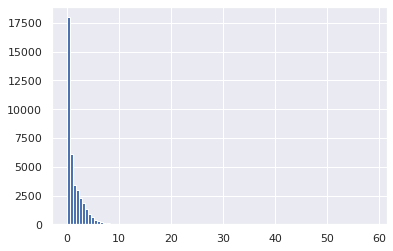

In [23]:
plt.hist(data['reviews_per_month'], bins=100)

(array([2.4141e+04, 6.3960e+03, 4.1390e+03, 2.2760e+03, 1.0260e+03,
        4.3500e+02, 2.1200e+02, 9.7000e+01, 5.6000e+01, 2.5000e+01,
        1.2000e+01, 1.4000e+01, 3.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e-02, 1.17980e+00, 2.34960e+00, 3.51940e+00, 4.68920e+00,
        5.85900e+00, 7.02880e+00, 8.19860e+00, 9.36840e+00, 1.05382e+01,
        1.17080e+01, 1.28778e+01, 1.40476e+01, 1.52174e+01, 1.63872e+01,
        1.75570e+01, 1.87268e+01, 1.98966e+01, 2.10664e+01, 2.22362e+01,
        2.34060e+01, 2.457

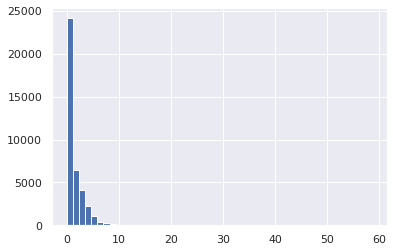

In [24]:
plt.hist(data['reviews_per_month'], bins=50)

<AxesSubplot:>

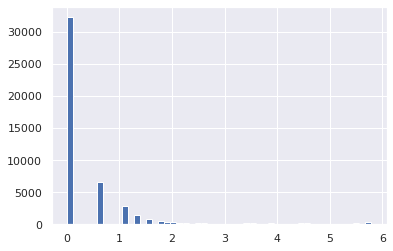

In [25]:
np.log(data['calculated_host_listings_count']).hist(bins=50)

(array([19554.,  1271.,   962.,   912.,   897.,   718.,   699.,   616.,
          613.,   658.,   686.,   809.,  1034.,   434.,   282.,   287.,
          332.,   439.,   329.,   320.,   389.,   567.,   405.,   534.,
          838.,   556.,   307.,   258.,   269.,   294.,   391.,   289.,
          330.,   433.,   477.,   356.,   499.,   352.,   551.,   332.,
          449.,   415.,   707.,   585.,   631.,   784.,  1057.,   630.,
          639.,  2719.]),
 array([  0. ,   7.3,  14.6,  21.9,  29.2,  36.5,  43.8,  51.1,  58.4,
         65.7,  73. ,  80.3,  87.6,  94.9, 102.2, 109.5, 116.8, 124.1,
        131.4, 138.7, 146. , 153.3, 160.6, 167.9, 175.2, 182.5, 189.8,
        197.1, 204.4, 211.7, 219. , 226.3, 233.6, 240.9, 248.2, 255.5,
        262.8, 270.1, 277.4, 284.7, 292. , 299.3, 306.6, 313.9, 321.2,
        328.5, 335.8, 343.1, 350.4, 357.7, 365. ]),
 <BarContainer object of 50 artists>)

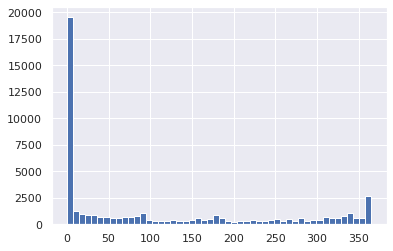

In [26]:
plt.hist(data['availability_365'], bins=50)
#посмотреть

In [27]:
#Тепловая карта
def heat_map_func(data):
    plt.figure(figsize=(20,19))
    nyc_img=plt.imread('New_York_City_.png', 0)
    #plt.imshow(nyc_img,zorder=0,extent=[-74.25, -73.80, 40.50,40.92])
    plt.imshow(nyc_img,zorder=0,extent=[-74.26, -73.70, 40.49,40.92])
    ax=plt.gca()
    data.plot(kind='scatter', x='longitude', y='latitude', label='NY_price', c='price', ax=ax, 
          cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
    plt.legend()
    plt.show()

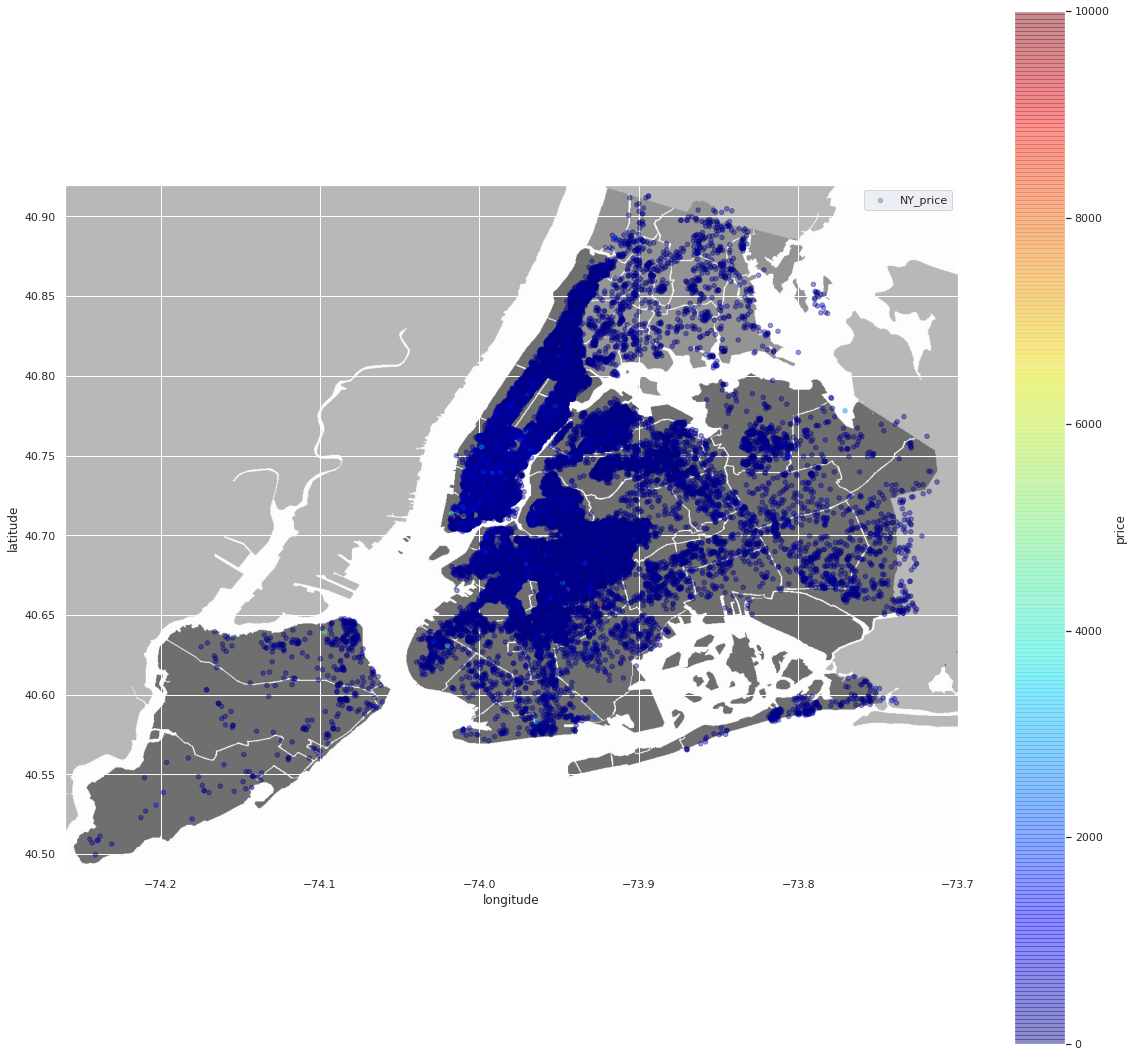

In [28]:
heat_map_func(data)

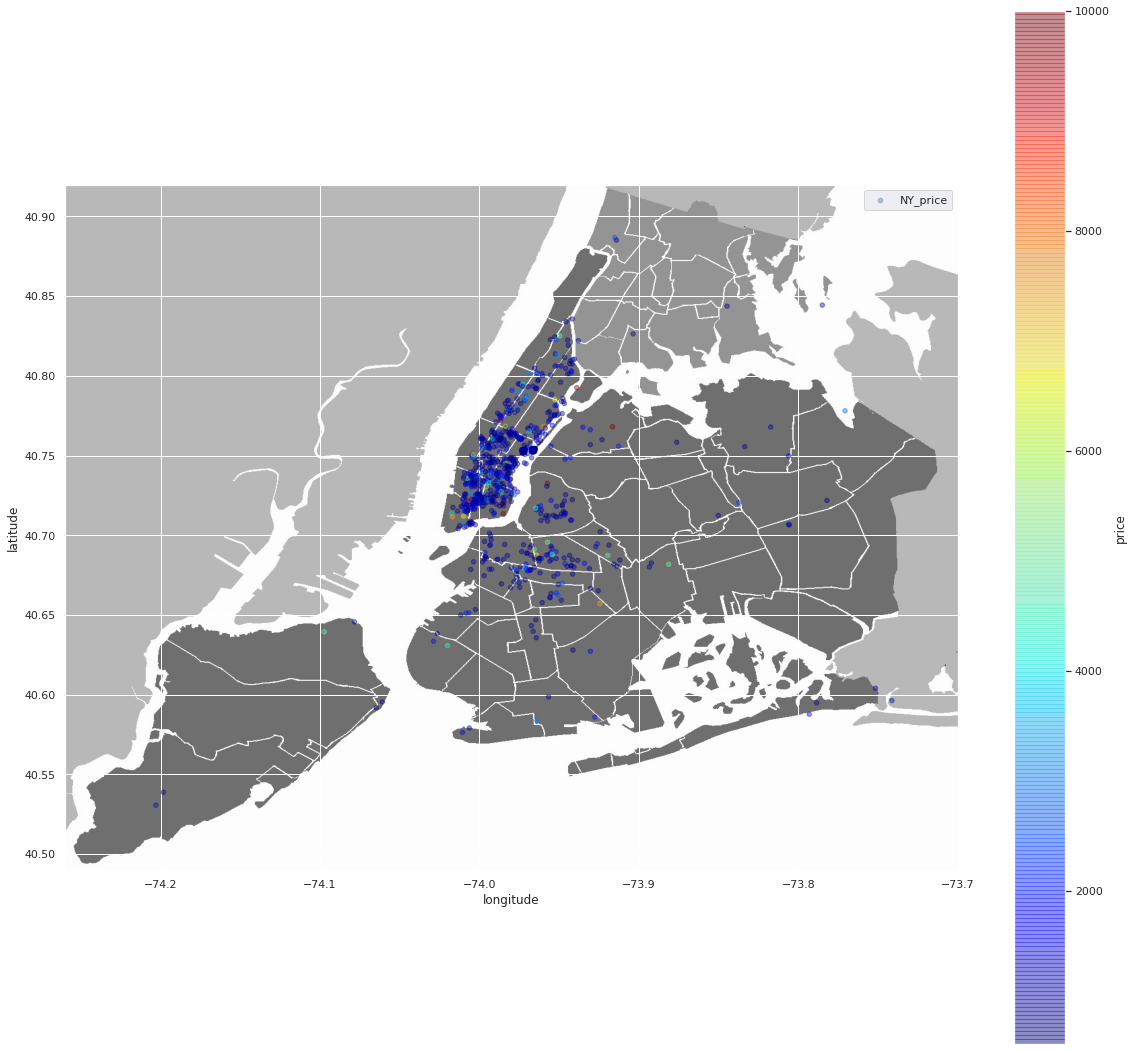

In [29]:
#Посмотрим на выбросы
#Дорогие
heat_map_func(data[data.price > 600])

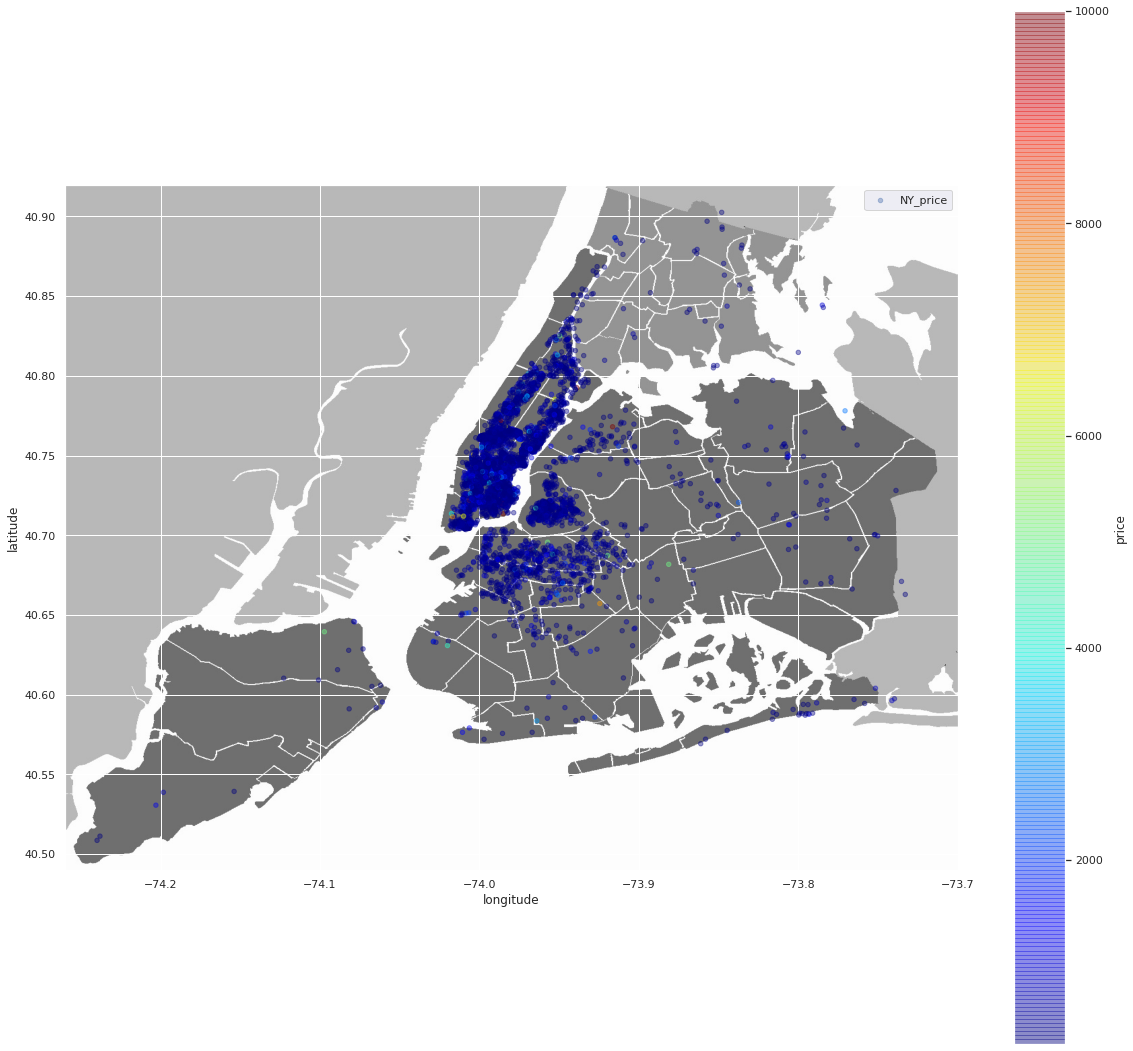

In [30]:
#Самые дорогие
heat_map_func(data[data.price > 269])

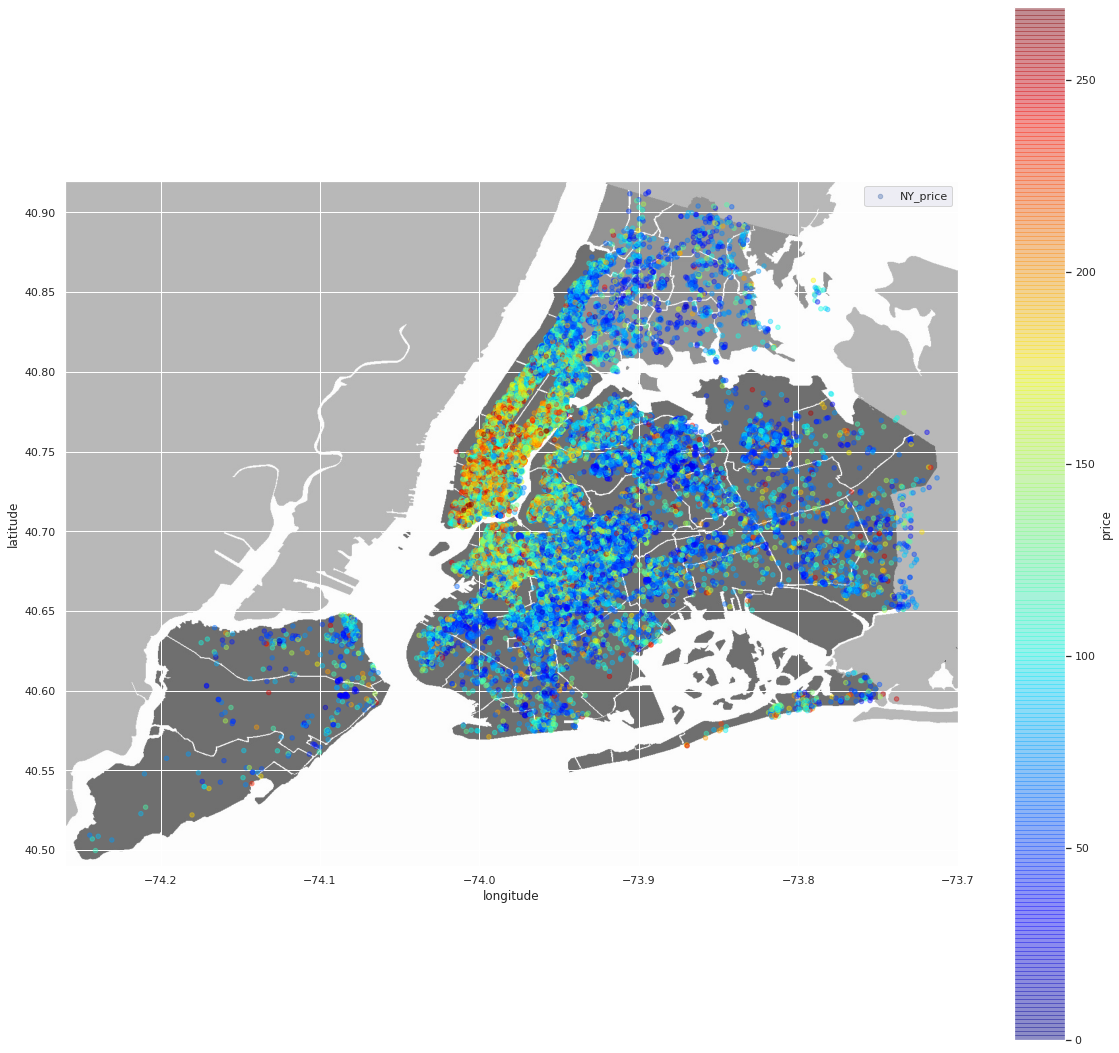

In [31]:
#Тепловая карта стоимости 90%
heat_map_func(data[data.price <= 269])

## Визуализации

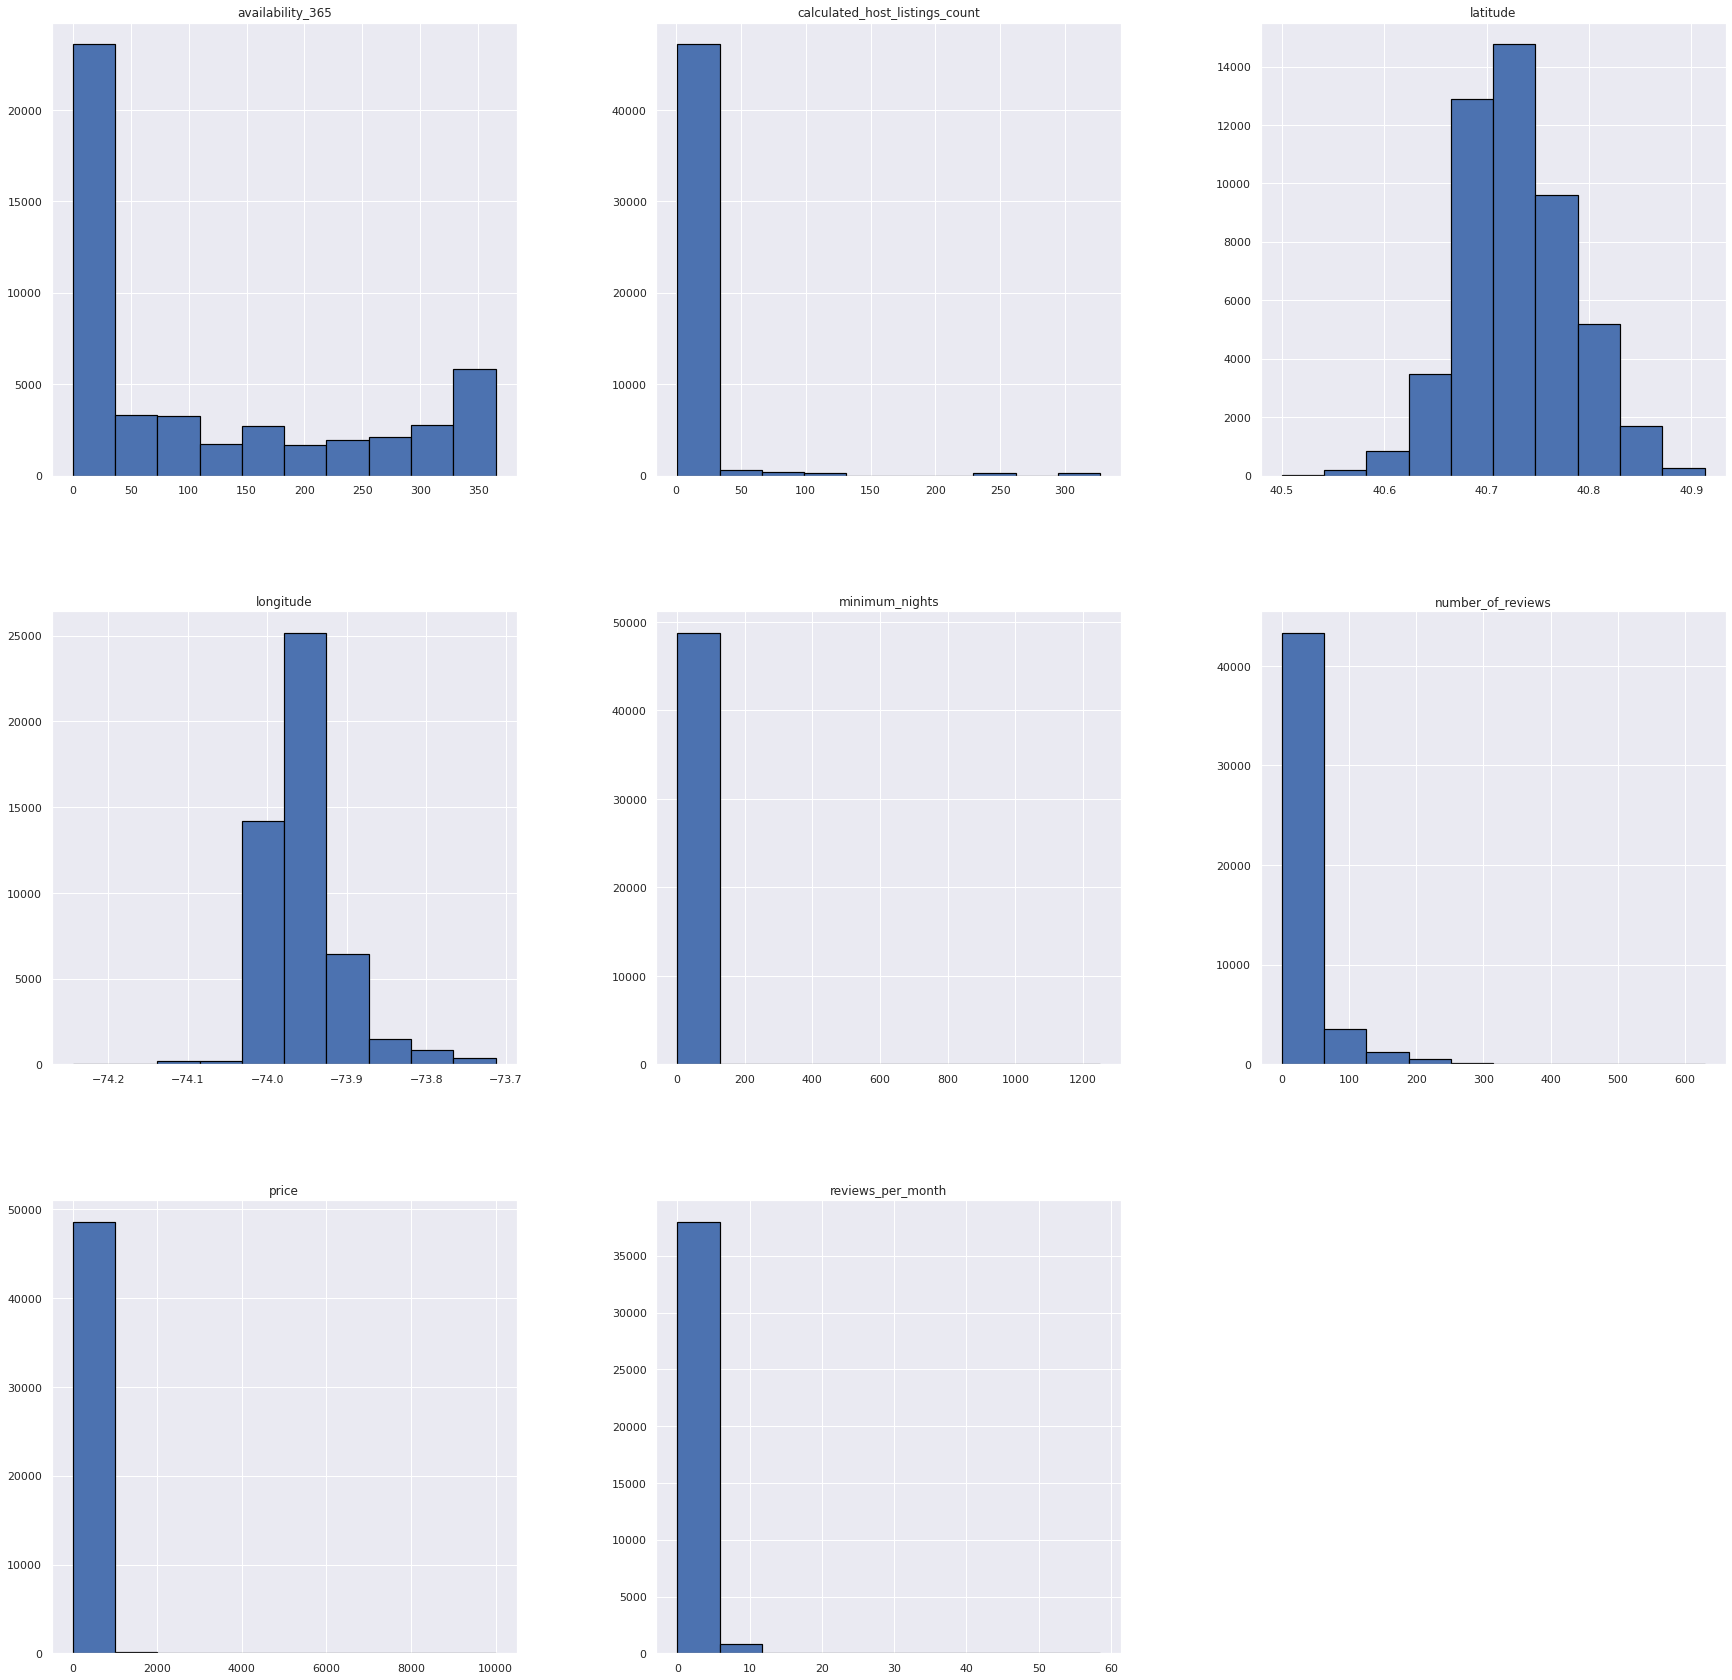

In [32]:
#Распределения
data.hist(edgecolor="black", linewidth=1.2, figsize=(30, 30));

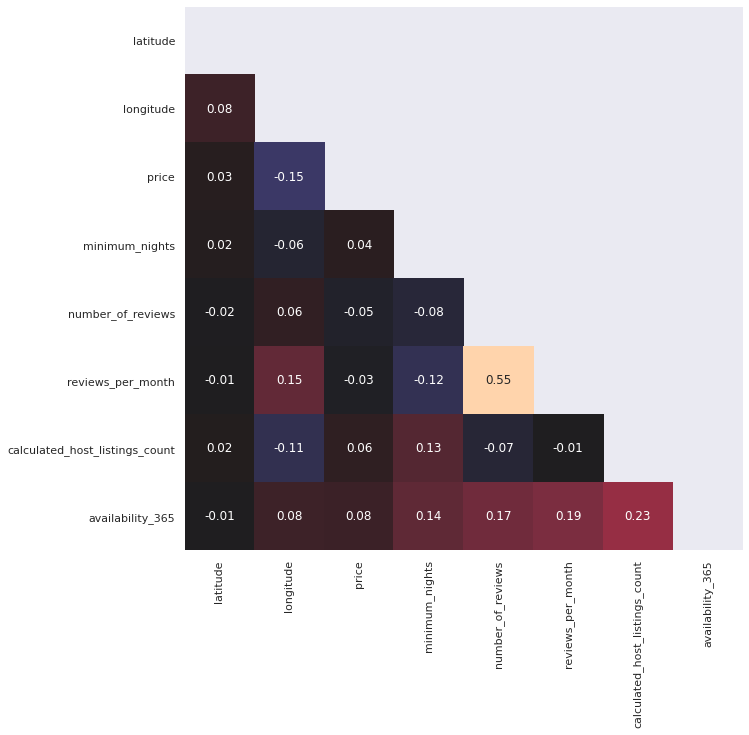

In [33]:
#Кореляция
plt.figure(figsize=(10,10))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);
#latitude longtitude - в чистом виде ничего не дают, преобразовать в растояние

In [34]:
# кол-во просмотров и просмотров в месяц сильно сколерированы. У reviews_per_month  много пропусков, можно убрать 
data.drop(["reviews_per_month"], axis="columns", inplace=True)

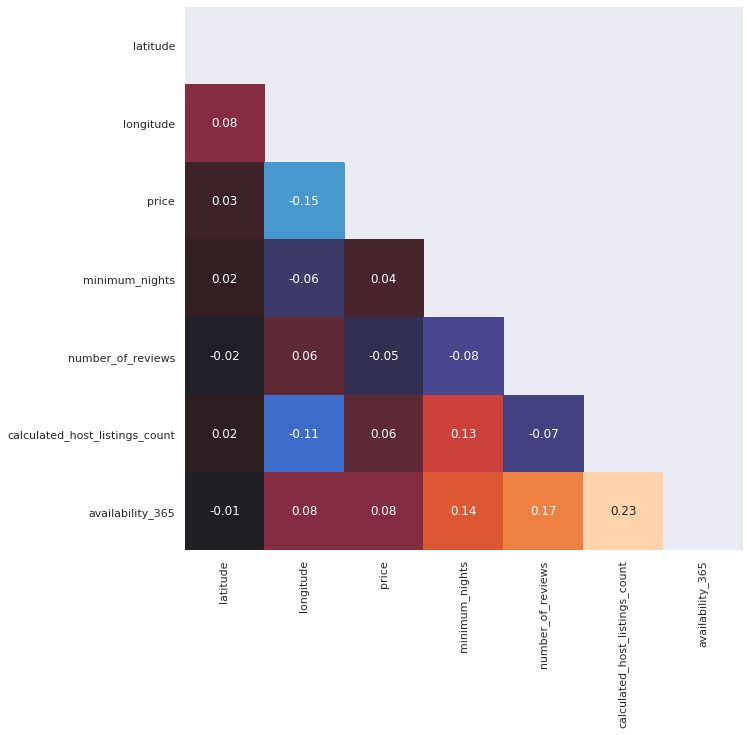

In [35]:
#Кореляция
plt.figure(figsize=(10,10))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [36]:
corr=data.corr(method='pearson')
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([0.61025564, 1.39338255, 1.23198779, 1.06025942, 0.99271947,
       0.83971552, 0.8716796 ])

#### 0 нет, следовательно сильной мультиколлинеарности нет

<Figure size 2160x2160 with 0 Axes>

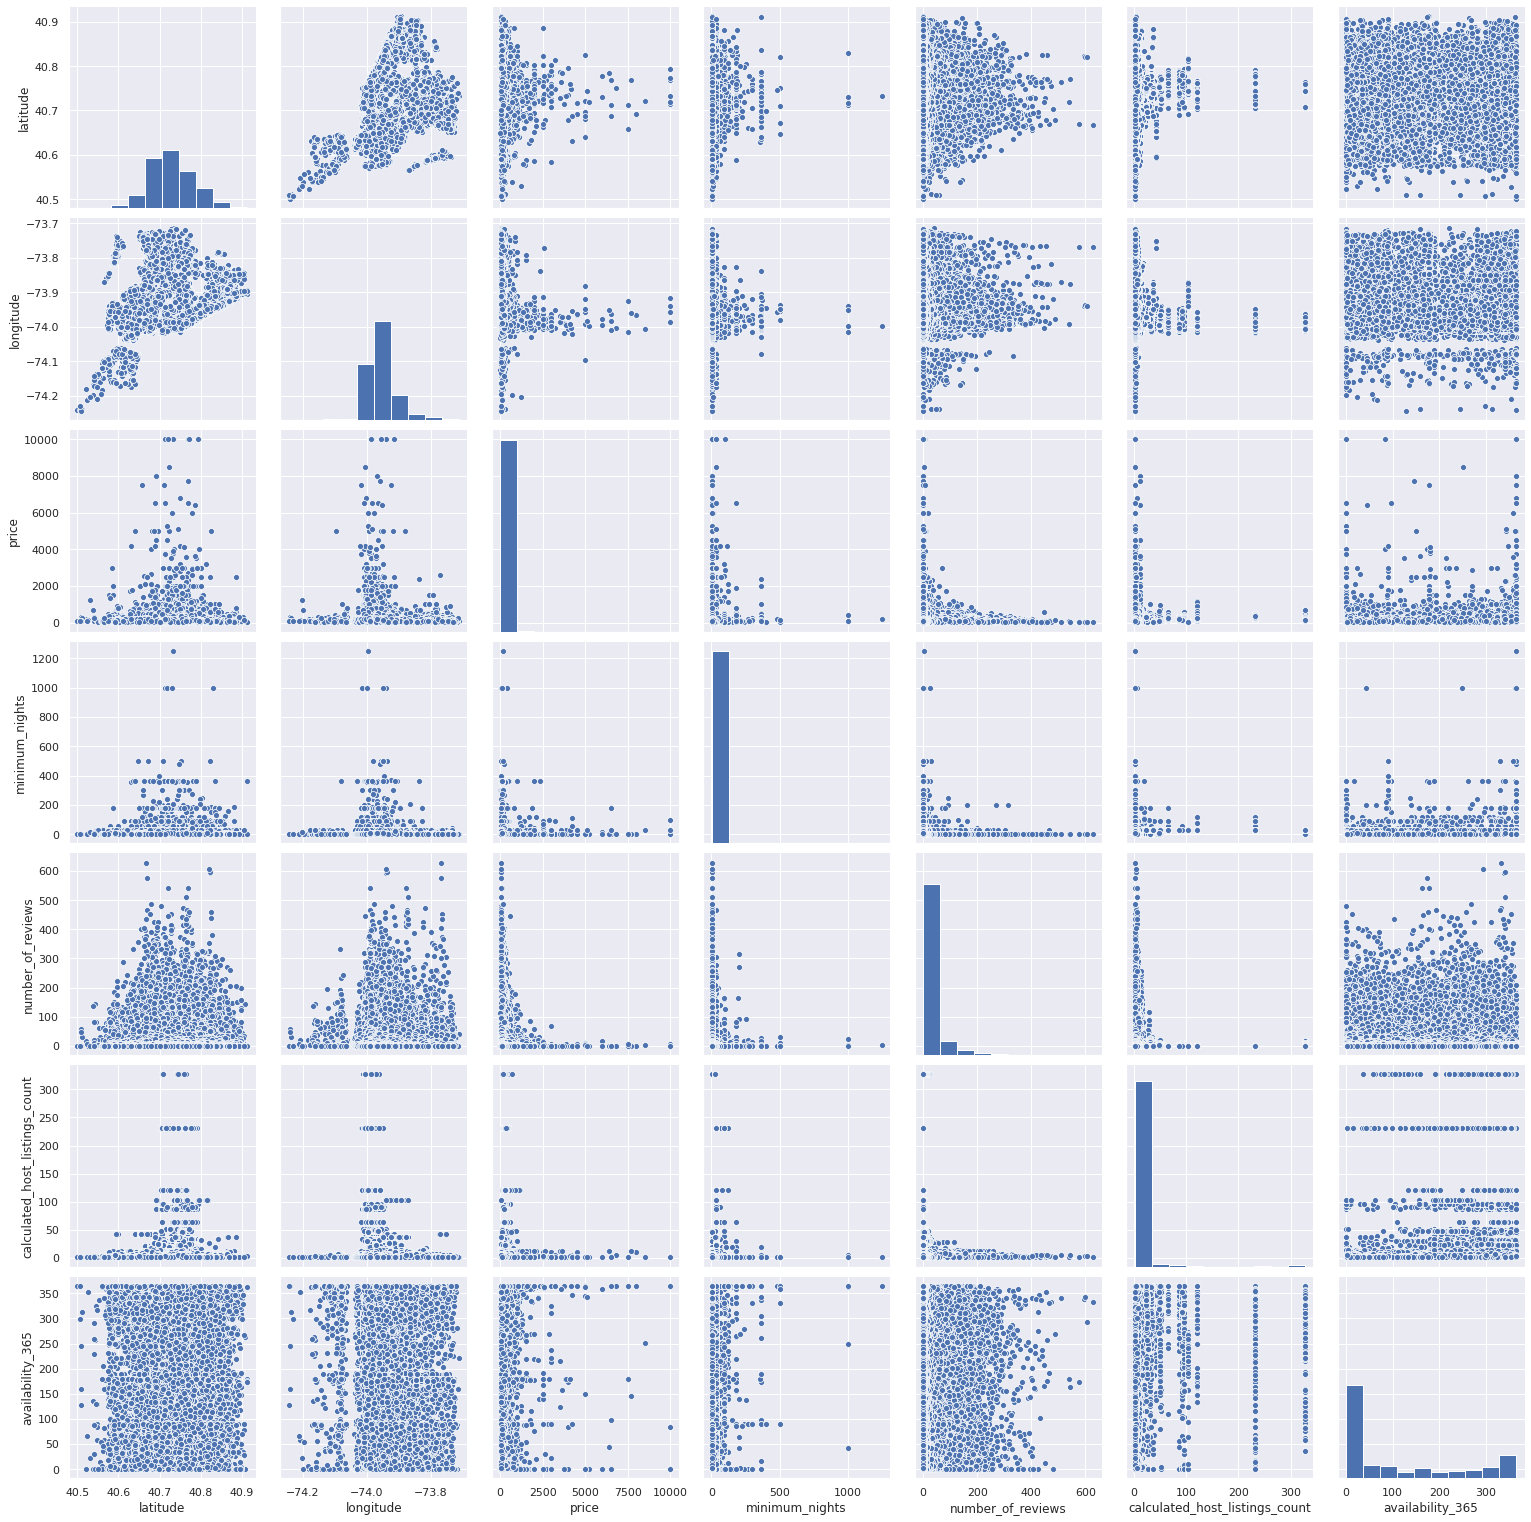

In [37]:
#pair plots
plt.figure(figsize=(30, 30))
sns.pairplot(data, height=3, diag_kind="hist")

# Попробовать маштаб цены порезать и добавить растояние

## Часть 2. Preprocessing & Feature Engineering

In [38]:
data.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365


In [39]:
#Категориальные переменные
categorical_features = data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))
categorical_features.head(4)

Categorical features: (48895, 3)


,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt


In [40]:
#работа с категориальными переменными (можно начать с dummy)
categorical_col = ['neighbourhood_group', 'room_type']
data = pd.get_dummies(data, columns=categorical_col)
#Сделаю neighbourhood частотное кодирование ниже 

In [41]:
#замена аномалий
data.head(3)

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Kensington,40.64749,-73.97237,149,1,9,6,365,0,1,0,0,0,0,1,0
1,Midtown,40.75362,-73.98377,225,1,45,2,355,0,0,1,0,0,1,0,0
2,Harlem,40.80902,-73.94190,150,3,0,1,365,0,0,1,0,0,0,1,0


327
1


count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
5%           1.000000
10%          1.000000
50%          1.000000
75%          2.000000
90%          5.000000
95%         15.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

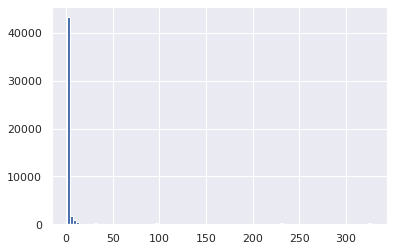

In [42]:
data['calculated_host_listings_count'].hist(bins=100)
print(data.calculated_host_listings_count.max())
print(data.calculated_host_listings_count.min())
data['calculated_host_listings_count'].describe(percentiles=[0.05,0.1, .75, .9, .95])

In [43]:
def outlier_detect_arbitrary(data, col, upper_fence, lower_fence):
    """Определяем выбросы по переданным границам."""
    params = (upper_fence, lower_fence)
    tmp = pd.concat([data[col] > upper_fence, data[col] < lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1]/len(outlier_index))    
    return outlier_index, params

In [44]:
def windsorization(data, col, params, strategy='both'):
    """Заменяем все значения большие params[1] значением params[1], а значения меньше params[0] значением params[0].
    При ``strategy = both`` - заменяем снизу и сверху,
        ``strategy = top`` - заменяем только сверху,
        ``strategy = bottom`` - заменяем только снизу."""
    data_copy = data.copy(deep=True)  
    if strategy == 'both':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
        data_copy.loc[data_copy[col] < params[1], col] = params[1]
    elif strategy == 'top':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col] < params[1], col] = params[1]  
    return data_copy

In [45]:
index, params = outlier_detect_arbitrary(data=data, col='calculated_host_listings_count', upper_fence=5, lower_fence=0)
print('Верхняя граница:', params[0], '\nНижняя граница:', params[1])
data = windsorization(data=data, col='calculated_host_listings_count', params=params, strategy='top')
print(data.calculated_host_listings_count.max())
print(data.calculated_host_listings_count.min())

Количество выбросов в данных: 4796
Доля выбросов: 0.09808773903262093
Верхняя граница: 5 
Нижняя граница: 0
5
1


In [46]:
data.head(3)

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Kensington,40.64749,-73.97237,149,1,9,5,365,0,1,0,0,0,0,1,0
1,Midtown,40.75362,-73.98377,225,1,45,2,355,0,0,1,0,0,1,0,0
2,Harlem,40.80902,-73.94190,150,3,0,1,365,0,0,1,0,0,0,1,0


In [47]:
#обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать
data['price'].describe(percentiles=[0.05,0.1, .75, .9, .95])

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
5%          40.000000
10%         49.000000
50%        106.000000
75%        175.000000
90%        269.000000
95%        355.000000
max      10000.000000
Name: price, dtype: float64

<AxesSubplot:>

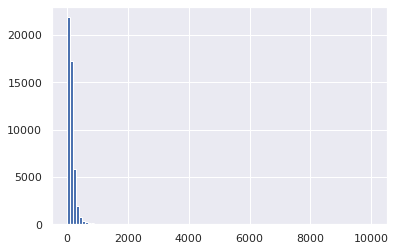

In [48]:
data['price'].hist(bins=100)

In [49]:
def drop_outlier(data, outlier_index):
    """Выкидываем выбросы."""
    data_copy = data[~outlier_index]
    return data_copy

In [50]:
index, params = outlier_detect_arbitrary(data=data, col='price', upper_fence=269, lower_fence=40)
print('Верхняя граница:', params[0], '\nНижняя граница:', params[1])
data = drop_outlier(data=data, outlier_index=index)
print(data.price.max())
print(data.price.min())
#обработать дорогое и дешевое тоже в отдельные группы

Количество выбросов в данных: 6920
Доля выбросов: 0.14152776357500768
Верхняя граница: 269 
Нижняя граница: 40
269
40


<AxesSubplot:>

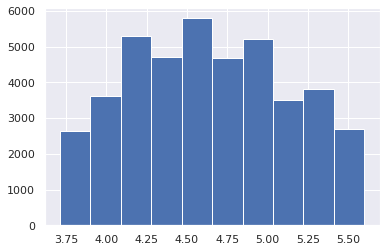

In [51]:
np.log(data['price']+1).hist()

In [52]:
data.head(3)

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Kensington,40.64749,-73.97237,149,1,9,5,365,0,1,0,0,0,0,1,0
1,Midtown,40.75362,-73.98377,225,1,45,2,355,0,0,1,0,0,1,0,0
2,Harlem,40.80902,-73.94190,150,3,0,1,365,0,0,1,0,0,0,1,0


In [53]:
data.isnull().sum()

neighbourhood                        0
latitude                             0
longitude                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
calculated_host_listings_count       0
availability_365                     0
neighbourhood_group_Bronx            0
neighbourhood_group_Brooklyn         0
neighbourhood_group_Manhattan        0
neighbourhood_group_Queens           0
neighbourhood_group_Staten Island    0
room_type_Entire home/apt            0
room_type_Private room               0
room_type_Shared room                0
dtype: int64

In [54]:
#Сгенерим новый признак на основе 'latitude','longitude' - расстояние от квартиры до Манхетена
data['Distance'] = data.apply(lambda x: gd.distance((40.7834, -73.9662), (x['latitude'], x['longitude'])).km, axis = 1)

In [55]:
data.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41975 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood                      41975 non-null  object 
 1   price                              41975 non-null  int64  
 2   minimum_nights                     41975 non-null  int64  
 3   number_of_reviews                  41975 non-null  int64  
 4   calculated_host_listings_count     41975 non-null  int64  
 5   availability_365                   41975 non-null  int64  
 6   neighbourhood_group_Bronx          41975 non-null  uint8  
 7   neighbourhood_group_Brooklyn       41975 non-null  uint8  
 8   neighbourhood_group_Manhattan      41975 non-null  uint8  
 9   neighbourhood_group_Queens         41975 non-null  uint8  
 10  neighbourhood_group_Staten Island  41975 non-null  uint8  
 11  room_type_Entire home/apt          41975 non-null  uin

In [57]:
data.isnull().sum()

neighbourhood                        0
price                                0
minimum_nights                       0
number_of_reviews                    0
calculated_host_listings_count       0
availability_365                     0
neighbourhood_group_Bronx            0
neighbourhood_group_Brooklyn         0
neighbourhood_group_Manhattan        0
neighbourhood_group_Queens           0
neighbourhood_group_Staten Island    0
room_type_Entire home/apt            0
room_type_Private room               0
room_type_Shared room                0
Distance                             0
dtype: int64

In [58]:
df.isnull().sum()

0

In [59]:
#Часть 3. Моделирование
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), data['price'], test_size=0.3, random_state=0)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41975 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood                      41975 non-null  object 
 1   price                              41975 non-null  int64  
 2   minimum_nights                     41975 non-null  int64  
 3   number_of_reviews                  41975 non-null  int64  
 4   calculated_host_listings_count     41975 non-null  int64  
 5   availability_365                   41975 non-null  int64  
 6   neighbourhood_group_Bronx          41975 non-null  uint8  
 7   neighbourhood_group_Brooklyn       41975 non-null  uint8  
 8   neighbourhood_group_Manhattan      41975 non-null  uint8  
 9   neighbourhood_group_Queens         41975 non-null  uint8  
 10  neighbourhood_group_Staten Island  41975 non-null  uint8  
 11  room_type_Entire home/apt          41975 non-null  uin

In [62]:
def drop_outlier(X_train, X_test, categorical_col, categorical_name):
    X_train[categorical_name] = X_train[categorical_col].map(X_train[categorical_col].value_counts(normalize=True))
    X_test[categorical_name] = X_test[categorical_col].map(X_train[categorical_col].value_counts(normalize=True))
    X_test[categorical_name].fillna(X_train[categorical_name].min(), inplace=True)
    X_train.drop([categorical_col], axis=1, inplace=True)
    X_test.drop([categorical_col], axis=1, inplace=True)

In [63]:
drop_outlier(X_train, X_test, 'neighbourhood', 'neighbourhood_encoded')

In [64]:
from sklearn.preprocessing import StandardScaler

#Шкалирование -?
TO_SCALE = [
    'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
    'availability_365', 'Distance', 'neighbourhood_encoded']
scaler = RobustScaler()
train_scaled_data = scaler.fit_transform(X_train[TO_SCALE])
test_scaled_data = scaler.transform(X_test[TO_SCALE])
X_train[TO_SCALE] = train_scaled_data
X_test[TO_SCALE] = test_scaled_data

In [65]:
X_train.head(3)

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,Distance,neighbourhood_encoded
27523,0.25,0.88,0.0,-0.176190,0,1,0,0,0,1,0,0,0.071213,1.397174
47365,0.00,-0.20,1.0,-0.004762,0,1,0,0,0,1,0,0,0.562366,1.275510
24594,-0.25,-0.24,1.0,-0.176190,0,0,1,0,0,1,0,0,-0.908675,0.291209


In [66]:
X_train.isnull().sum()

minimum_nights                       0
number_of_reviews                    0
calculated_host_listings_count       0
availability_365                     0
neighbourhood_group_Bronx            0
neighbourhood_group_Brooklyn         0
neighbourhood_group_Manhattan        0
neighbourhood_group_Queens           0
neighbourhood_group_Staten Island    0
room_type_Entire home/apt            0
room_type_Private room               0
room_type_Shared room                0
Distance                             0
neighbourhood_encoded                0
dtype: int64

In [67]:
# подгружаем метрики
#метрики качества (можно взять несколько, R2, MAE, RMSE)
#Средняя абсолютная ошибка (MAE) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными посредством усредненной абсолютной разницы по набору данных.
#Среднеквадратическая ошибка (RMSE) это частота ошибок, вычисляемая квадратным корнем из MSE.
#Коэффициент детерминации (R2) - описявает качество модели. Чем выше значение, тем лучше модель (от 0 до 1, 1 идеальный)
#Средняя абсолютнаяпроцентная ошибка (MAPE) - процент кол-ва ошибок
#Среднеквадратическая ошибка (MSE) - представляет собой разницу между исходным и прогнозируемым значениями, извлеченными путем возведения в квадрат средней разницы по набору данных.
from sklearn import metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [68]:
y_mean = np.median(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
measured_metrics["y_pred_naive"] = dataframe_metrics(y_test, y_pred_naive)
measured_metrics

,error_type,y_pred_naive
0,MAE,46.632415
1,RMSE,59.797466
2,R2,-0.080766
3,MAPE,44.163643


In [69]:
#2. Постройте модели простой линейной регрессии
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)

# Обучили модель на тренировочной выборке 
lin_reg.fit(X_train,y_train)
# Сделали прогнозы на тестовой выборке 
lin_reg_predict = lin_reg.predict(X_test)
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg_predict)
measured_metrics

,error_type,y_pred_naive,lin_reg
0,MAE,46.632415,32.294315
1,RMSE,59.797466,42.105812
2,R2,-0.080766,0.464142
3,MAPE,44.163643,31.591208


In [90]:
###Ridge
# Объявили модель
ridge_x = Ridge(alpha = 0.01)

# Обучили модель на тренировочной выборке 
ridge_x.fit(X_train,y_train)
# Сделали прогнозы на тестовой выборке 
pred_ridge_x = ridge_x.predict(X_test)

measured_metrics["pred_ridge"] = dataframe_metrics(y_test, pred_ridge_x)
measured_metrics

,error_type,y_pred_naive,lin_reg,pred_ridge,lasso_cv,elastic_cv
0,MAE,46.632415,32.294315,32.294316,32.295237,32.476325
1,RMSE,59.797466,42.105812,42.105811,42.103165,42.190684
2,R2,-0.080766,0.464142,0.464142,0.464209,0.461979
3,MAPE,44.163643,31.591208,31.591213,31.593602,31.974964


In [93]:
###RidgeCV
from sklearn.linear_model import RidgeCV
# Объявили модель
ridge_cv = RidgeCV(cv=5)

# Обучили модель на тренировочной выборке 
ridge_cv.fit(X_train,y_train)
print('Лучшее значение параметра:', ridge_cv.alpha_)
# Сделали прогнозы на тестовой выборке 
pred_ridge_x = ridge_cv.predict(X_test)

measured_metrics["ridge_cv"] = dataframe_metrics(y_test, pred_ridge_x)
measured_metrics

Лучшее значение параметра: 10.0


,error_type,y_pred_naive,lin_reg,pred_ridge,lasso_cv,elastic_cv,ridge_cv
0,MAE,46.632415,32.294315,32.294316,32.295237,32.476325,32.295765
1,RMSE,59.797466,42.105812,42.105811,42.103165,42.190684,42.104481
2,R2,-0.080766,0.464142,0.464142,0.464209,0.461979,0.464176
3,MAPE,44.163643,31.591208,31.591213,31.593602,31.974964,31.595773


In [88]:
from sklearn.linear_model import LassoCV

# Объявили модель
lasso_cv = LassoCV(cv=5)

# Обучили модель на тренировочной выборке 
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)
# Сделали прогнозы на тестовой выборке 
y_pred_lasso = lasso_cv.predict(X_test)

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

Лучшее значение параметра: 0.0176058008831682


,error_type,y_pred_naive,lin_reg,pred_ridge,lasso_cv,elastic_cv
0,MAE,46.632415,32.294315,32.294316,32.295237,32.476325
1,RMSE,59.797466,42.105812,42.105811,42.103165,42.190684
2,R2,-0.080766,0.464142,0.464142,0.464209,0.461979
3,MAPE,44.163643,31.591208,31.591213,31.593602,31.974964


In [72]:
from sklearn.linear_model import ElasticNetCV

# Объявили модель
elastic_cv = ElasticNetCV(cv=5)

# Обучили модель на тренировочной выборке 
elastic_cv.fit(X_train, y_train)
# Сделали прогнозы на тестовой выборке 
y_pred_elastic = elastic_cv.predict(X_test)

# Измерьте качество
measured_metrics["elastic_cv"] = dataframe_metrics(y_test, y_pred_elastic)
measured_metrics

,error_type,y_pred_naive,lin_reg,pred_ridge,lasso_cv,elastic_cv
0,MAE,46.632415,32.294315,32.451071,32.295237,32.476325
1,RMSE,59.797466,42.105812,42.144870,42.103165,42.190684
2,R2,-0.080766,0.464142,0.463147,0.464209,0.461979
3,MAPE,44.163643,31.591208,31.963847,31.593602,31.974964


In [73]:
#визуализируйте важность признаков
def featureImportancefunc(X_train, model):
    featureImportance = pd.DataFrame({"feature": X_train.columns[model.coef_!=0], 
                                  "importance": model.coef_[model.coef_!=0]})
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

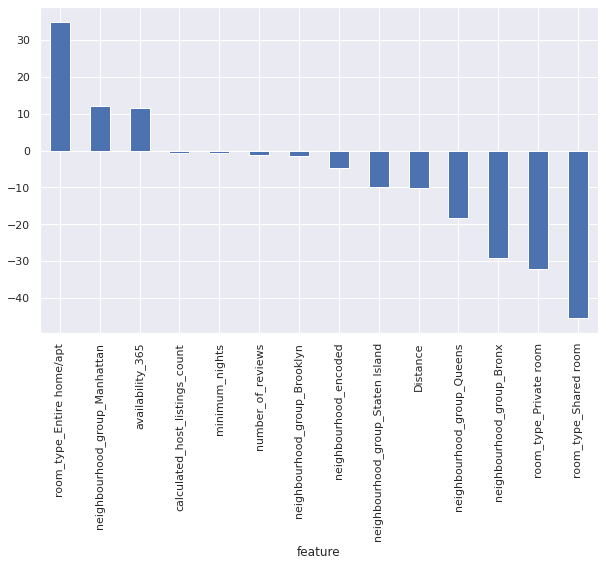

In [74]:
featureImportancefunc(X_train, lin_reg);

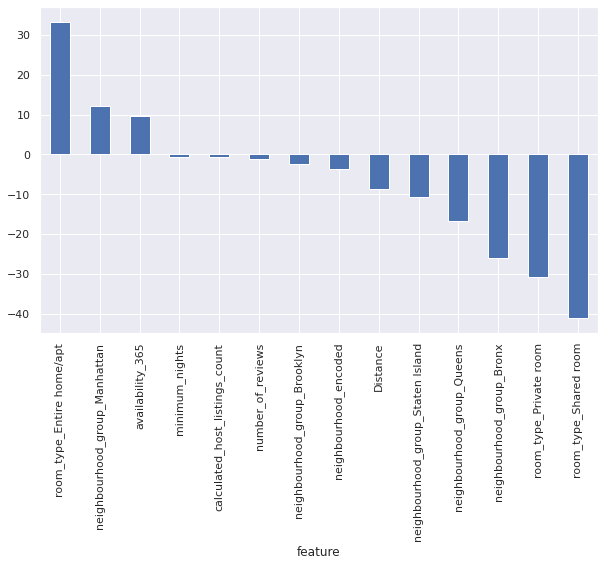

In [75]:
featureImportancefunc(X_train, ridge_x);

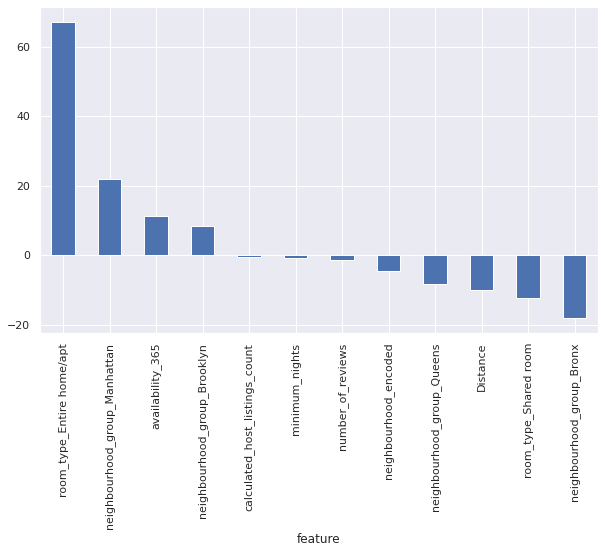

In [76]:
featureImportancefunc(X_train, lasso_cv);

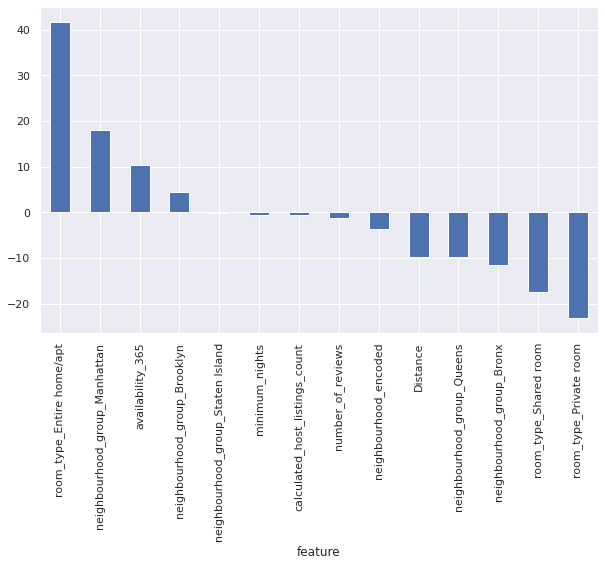

In [77]:
featureImportancefunc(X_train, elastic_cv);

In [78]:
#Ожидаемо Манхетен и апартаменты влияют на рост цены, совместная комната и районы бронкса и квинса влияют на понижение цены во всех моделях 
#По метрикам качества все модели показали примерно одинаковый результат качества прогноза, lin_reg лучше
# хотелось бы понять почему такое низкое значение R2 и высокие значения метрик ошибок. 
# Что не так и что можно улучшить?